# 기본 함수 및 라이르러리 로드

###### 라이브러리 로드

In [1]:
# 기초 전처리
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
%matplotlib inline

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

## 필요 함수 로드

In [2]:
def get_object_type(df):
    df['상권_코드'] = df['상권_코드'].apply(lambda x : str(x))
    df.astype({'상권_코드':object})
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

In [4]:
# 피밸류 보는 함수
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
def get_summary(X,y):
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_VIF(df):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

## 검정 함수

### vif 관련 함수

In [6]:
def get_vif(X, least=100):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # 피처마다의 VIF 계수를 출력(소수점 4째자리까지만 출력)
    pd.options.display.float_format = '{:.4f}'.format

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    print(vif)
    print('\n')
    return vif[vif['VIF Factor']>least]

In [7]:
def get_corr(df):

    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

### AIC 기반 회귀 함수

In [8]:
def processSubset(X,y,feature_set):

    feature = list(feature_set) 
    model = sm.OLS(y,X[feature]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    data = regr.summary()
    return {"model" : regr, "AIC" : AIC, "SUMMARY":data, "Features":feature}
    

In [9]:
import time
import itertools 

# getBest : 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수

def getBest(X,y,k):
    tic = time.time()      # 시작 시간
    results = []           # 결과 저장 공간
    for combo in itertools.combinations(X.columns.difference(['const']),k):
        # 각 변수 조합을 고려한 경우의수
        
        combo = (list(combo)+['const'])
        # 상수항을 추가하여 combo를 결성
        
        results.append(processSubset(X,y,feature_set = combo)) # 모델링된것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분석하여
        # 저장 후 그 중 AIC가 가장 낮은 모델을 선택하도록 함

    models = pd.DataFrame(results) # 데이터프레임으로 모델결과 변환
    best_model = models.loc[models['AIC'].argmin()] # argmin은 최소값의 인덱스를 뽑는 함수
    toc = time.time()       # 종료 시간
    print("Processed", models.shape[0], "models on", k, "predictors in",(toc - tic),"seconds.")
    
    return best_model

###### 전진선택법

In [10]:
### 전진석택법(step=1)

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
### 전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    return Fmodels
#     return (Fmodels['model'][len(Fmodels['model'])])


###### 후진소거법

In [11]:
### 후진소거법(step=1)

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model","SUMMARY","Features"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[idx] = Backward_result
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
        idx+=1
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels.dropna()
#     return Bmodels["model"].dropna().iloc[0]

#### 단계적 선택법

In [12]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    predictors = []
    Stepmodels.loc[1] = getBest(X,y,k=1)
#     Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    predictors = Stepmodels.loc[1]['model'].model.exog_names
    predictors = [k for k in predictors if k != "const"]
    print(predictors)
    Smodel_before = Stepmodels.loc[1]['AIC']
    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(2,len(X.columns.difference(['const']))+1) :
        print('step:',i-1)

        Forward_result = forward(X=X,y=y,predictors = predictors ) # constant added
        Backward_result = backward(X=X,y=y,predictors = predictors)
        
        
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('backward')
            
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('##forward##')
            
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
            
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Stepmodels
#     return (Stepmodels["model"][len(Stepmodels["model"])])

###### AIC 시각화

In [13]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')
 
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC  = result['AIC'].to_list()
    features = [f'step {i+1}\n'+'\n'.join(s) for i,s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps,AIC, marker='o')
    
    plt.ylabel('AIC',fontsize=font_size)
    plt.grid(True)
    plt.show()
 

### R-square 기반

#### 전진선택법

In [14]:
def forward_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])

    ## 전진 선택법
    variables = df_X.columns.tolist() ## 설명 변수 리스트

    # df_y= df['Survival_Time'] ## 반응 변수
    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = df_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(df_y,X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())

            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit().rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
        
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return df_result


#### 후진선택법

In [15]:
def backward_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])
    ## 후진 소거법
    variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트

    # df_y= df_X['Survival_Time'] ## 반응 변수
    selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(selected_variables) > 0:
        X = sm.add_constant(df_X[selected_variables])
        p_vals = sm.OLS(df_y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
        max_pval = p_vals.max() ## 최대 p-value
        if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
            remove_variable = p_vals.idxmax()
            selected_variables.remove(remove_variable)

            step += 1
            steps.append(step)
            model = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit()
            adj_r_squared = model.rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()
    
    return df_result




#### 단계적 선택법

In [16]:
def stepwise_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])
    ## 전진 단계별 선택법
    variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트

    # df_y= df_X['Survival_Time'] ## 반응 변수
    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = df_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(df_y,X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = df_X[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(df_y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break

            step += 1
            steps.append(step)
            model = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit()
            adj_r_squared = model.rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return df_result

###### 자료 로드

###### base 생성

In [17]:
bs_area = gpd.read_file('data/geojson/상권_geometry_좌표.geojson', driver= 'GeoJSON')
bs_area= bs_area[bs_area['TRDAR_SE_C'] == 'A']
df_base = bs_area[['TRDAR_CD','TRDAR_SE_1']].sort_values('TRDAR_CD').reset_index(drop=True)
df_base.columns = ['상권_코드', '상권_이름']
df_base = get_object_type(df_base)
df_base.head()

,상권_코드
0,1000001
1,1000002
2,1000003
3,1000004
4,1000005


#   4대지표 정리

## 1. 상권이 얼마나 발달했는가?

* 단순지표

1. 총매출

2. 고객수를 대표 할 지수

3. 점포의 수

5. 유동인구

5. 가게 생존률 : 개폐업률

6. 면적

*  복합지표



1. 면적대비 매출

2. 점포수 대비 매출

3. 면적 대비 점포수

1. 재방문율? 고정 방문 고객수? 

In [18]:
df_i1_development = pd.read_csv('data/indicator/상권_발달_지수.csv')
df_i1_development = get_object_type(df_i1_development)
df_i1_development

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00,3.75,2.25,1.433523e+10,0.872042,148.215330,16.627639,29.815076
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75,5.00,5.50,2.084769e+10,0.826819,200.467009,84.359420,15.420539
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00,4.50,3.50,3.196072e+10,0.709322,218.518656,71.899687,59.211507
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00,4.50,3.50,8.668921e+09,1.004444,182.190421,36.836315,24.889402


##  2. 상권의 고객층은 어떠한가?

* 단순지표

1. 업종별 매출 금액 : 
2. 요일별 매출 금액 : 구성(비율) -  실 거래가도 필요!!
3. 소득 수준 : 변형 방식 잘못됨 - 원래 값 가지고 오면,  정규화 하느게 나을거 같음!
4. 성별?! : 매출에 대한 비율, 실 거래가 필요!!
5. 연령?! : 매출에 대한 비율, 실 거래가 필요 !!


* 복합지표

1. 상권의 다양성 : ok!
2. 고객의 유입성 - 매출을 고객수로 나누어야 하는거 아닌가? 
3. 라이프 지수?!

* 부탁 : 총직장 인구수 --> 상권 발달 지수로 편입

In [19]:
df_i2_diversity = pd.read_csv('data/indicator/상권_다양성_지수.csv')
df_i2_diversity = get_object_type(df_i2_diversity)
df_i2_diversity

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,유흥_비율,패션/미용_비율,교육_비율,요식_비율,의료_비율,자동차_비율,기타_비율,유통업_비율,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,남성_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,남성_매출_금액_비율,여성_매출_금액_비율,상권별_소득금액,다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,2.383339e+07,3.140614e+08,1.844958e+08,3.401026e+09,1.098479e+08,2.162874e+07,1.104666e+09,7.539225e+08,0.004030,0.053109,0.031199,0.575131,0.018576,0.003658,0.186805,0.127492,1.793861e+09,1.989043e+09,2.249773e+09,2.002910e+09,2.336899e+09,2.775185e+09,1.978902e+09,5.268174e+09,8.349831e+09,0.062407,0.069197,0.078268,0.069680,0.081299,0.096546,0.068844,0.386854,0.613146,56459184,3.431027,3497.822761,2.760323e+05,54800
1,1000002,3.323505e+07,1.233347e+09,0.000000e+00,2.824262e+08,0.000000e+00,1.649548e+07,2.757601e+08,5.625196e+08,0.013826,0.513086,0.000000,0.117492,0.000000,0.006862,0.114719,0.234014,1.864865e+09,1.861095e+09,2.020037e+09,2.010279e+09,2.507377e+09,3.009626e+09,2.721385e+09,6.232730e+09,9.299999e+09,0.059151,0.059031,0.064072,0.063763,0.079530,0.095461,0.086318,0.401264,0.598736,52528944,3.090867,1097.584441,3.396471e+05,47092
2,1000003,2.687648e+08,6.158692e+08,5.146111e+09,2.088953e+09,3.048000e+06,9.421422e+07,4.283574e+08,7.717781e+08,0.028540,0.065399,0.546465,0.221826,0.000324,0.010005,0.045487,0.081955,4.151880e+09,4.147718e+09,4.099405e+09,3.529069e+09,4.115786e+09,6.076924e+09,2.622511e+09,1.490993e+10,1.083067e+10,0.076204,0.076127,0.075241,0.064773,0.075541,0.111536,0.048134,0.579238,0.420762,46548880,3.492629,4147.017560,1.818920e+05,158024
3,1000004,2.845950e+06,2.521403e+07,5.960735e+07,1.048493e+09,1.619301e+08,1.963030e+07,2.291818e+08,9.595252e+08,0.001135,0.010060,0.023782,0.418322,0.064606,0.007832,0.091438,0.382826,1.677315e+09,1.723738e+09,1.796036e+09,1.495531e+09,1.689890e+09,1.324265e+09,1.015283e+09,5.602198e+09,4.587237e+09,0.080210,0.082430,0.085888,0.071517,0.080812,0.063327,0.048551,0.549805,0.450195,47223072,2.480483,846.936653,1.580492e+06,6784
4,1000005,0.000000e+00,1.305581e+08,8.196169e+07,4.654974e+09,0.000000e+00,1.527319e+09,5.503179e+08,4.557695e+08,0.000000,0.017641,0.011075,0.628974,0.000000,0.206369,0.074358,0.061583,8.446228e+08,1.235422e+09,1.465347e+09,1.186086e+09,1.481575e+09,2.264371e+09,1.957322e+09,4.489870e+09,4.827498e+09,0.042761,0.062546,0.074187,0.060049,0.075008,0.114639,0.099094,0.481882,0.518118,63642816,3.274153,5668.408506,6.135199e+05,17008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,2.512648e+07,1.447867e+08,2.804269e+08,1.181328e+09,2.466564e+07,2.065871e+08,9.684341e+08,1.122737e+09,0.006355,0.036617,0.070921,0.298761,0.006238,0.052246,0.244919,0.283943,1.766752e+09,1.910530e+09,1.910759e+09,2.026241e+09,1.659804e+09,1.935173e+09,1.291661e+09,6.268783e+09,5.806702e+09,0.071888,0.077738,0.077748,0.082447,0.067536,0.078741,0.052557,0.519133,0.480867,48022416,3.577553,541.685637,1.472776e+06,8488
1006,1001007,3.343640e+06,1.694507e+08,7.354804e+07,1.514327e+09,1.984390e+08,5.059799e+09,1.252837e+09,6.572703e+09,0.000225,0.011415,0.004955,0.102013,0.013368,0.340855,0.084398,0.442772,2.363785e+09,2.517307e+09,3.468178e+09,2.780483e+09,2.931596e+09,2.226779e+09,9.491458e+08,1.078403e+10,5.365248e+09,0.070801,0.075399,0.103879,0.083282,0.087808,0.066697,0.028429,0.667772,0.332228,40991088,3.407494,3053.619034,4.460992e+06,3864
1007,1001008,3.649771e+07,3.771270e+08,2.032622e+07,3.218844e+09,0.000000e+00,3.447343e+07,2.286670e+08,3.225350e+08,0.008611,0.088977,0.004796,0.759435,0.000000,0.008133,0.053950,0.076097,2.678396e+09,3.042313e+09,3.040061e+09,3.019629e+09,3.781381e+09,4.055309e+09,3.053337e+09,1.371922e+10,8.391559e+09,0.059811,0.067937,0.067887,0.067431,0.084441,0.090558,0.068183,0.620477,0.379523,44387424,3.228552,780.36

In [20]:
df_i2_diversity.columns = [x.replace('다양성_지수', '고객_다양성_지수') for x in df_i2_diversity.columns]

## 3. 상권의 지리적 특성은 어떠한가?

In [21]:
df_i3_geo = pd.read_csv('data/indicator/상권_지리적_지표.csv')
df_i3_geo = get_object_type(df_i3_geo)
df_i3_geo

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,다양성_지수
0,1000001,4.675446e+06,544.0,2800.0,582.0,245.0,3.917831e-09,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.777462
1,1000002,3.689914e+06,179.0,4372.0,5775.0,2984.0,4.348221e-09,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.796312
2,1000003,1.241185e+07,32.0,982.0,1386.0,0.0,5.626303e-09,29.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,4.0,2.0,0.0,1.082380
3,1000004,4.357117e+06,917.0,4753.0,2021.0,124.0,6.733993e-09,8.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.970116
4,1000005,1.612400e+06,421.0,1210.0,2220.0,1006.0,2.961807e-09,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,4.224173e+06,853.0,6621.0,15482.0,3488.0,4.517399e-09,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.636514
1006,1001007,2.451149e+06,377.0,2274.0,1092.0,0.0,6.468466e-09,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.960892
1007,1001008,4.373616e+06,590.0,3890.0,4402.0,44.0,5.391740e-09,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.636514
1008,1001009,4.373616e+06,765.0,4435.0,8920.0,2724.0,4.930576e-09,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.848686


In [22]:
df_i3_geo.columns = [x.replace('다양성_지수', '지리_다양성_지수') for x in df_i3_geo.columns]

##  4. 문화적 코드는 어떠한가?

* 단순지표

1. 상권별 단순 좋아요 표현

* 범위를 어떻게 나눌까?  빈도수 각상권만의 빈도수로 하기에는 1010 너무 많아 무의미 하고


* 문화적 코드를 제외하고서  클러스터링 할꺼자나: 클러스터링 한 레이블 값: 상권 상호 보안적으로 나가는거지

* 15나눴더니... 문화적 5개로 나눠진다...

 나눈 다른 코드에서 나누어진 클러스터링 값에 따른 빈도수 / 서울 전체 빈도수 
 
 
 
///////////////////////


이제부터 분석인데!!




// 클러스터링 // 

일단 , 리뷰 식당 이니까... 대표성 

상권 쳐먹!!... 안타 까운

-------------------------

의류 / 패션 


숫자...

어떤 의미를 가지는 숫자를
구하는냐?



리뷰 데이터를 어떻게 정형화 해서 각 상권_코드 숫자를 줄것인가?

    레이블 주거나!!
    
    

클러스터링/// 1010 // 주요 클러스터를 10 ~ 20 개 유사도를 판별하는 

결론 : 솔루션

부족한지를 찾아주는게 좋은데

일치도를 사용 해서

클러스터링 

-------------------------

잘 나가는 대표 을 보고 . 

그 수치값  점포당 유동인구수 나 활동인구수 == 

다양성 이 떨어진다거나... 리뷰 숫자가 적거나 문화정 지수 xxxxxxxxxx  

같은 조건 임에도 불구하고 찾을 수가 없다. 


---> 거리를 지정해서, 문화 공연

위드 코로나 행사 마련 

추천 시스템

df_i4_culture = 

1. 다중공성선 평가 : VIF

2. Feature Selection : Stepwise, 



1. 단순 지표로 



2. 경향성을 보는 거면 될꺼 같애 회귀 계수 




# 회귀를 통한 영향력 평가

## 4대지표 1차 가공

### 종속변수 설정

In [23]:
# # 20_3_4~21_1_2 분기 회귀 계수
# df_t_total = pd.read_csv('data/j_result/수정_매출_회귀계수.csv')
# df_t_total = get_object_type(df_t_total)

df_t_total

20_3_4~21_1_2 분기 회귀 계수는 우선 사용 하지 말고,

In [24]:
df_1년매출 = df_i1_development.iloc[:,:2]

In [25]:
# 1년 매출
df_1년매출

,상권_코드,1년_매출
0,1000001,1.512657e+10
1,1000002,1.599466e+10
2,1000003,2.874329e+10
3,1000004,1.072206e+10
4,1000005,1.043475e+10
...,...,...
1005,1001006,1.250092e+10
1006,1001007,1.723727e+10
1007,1001008,2.267043e+10
1008,1001009,8.707442e+09


### 발달지수

In [26]:
df_i1_development.head()

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101


In [27]:
df_i1_development = df_i1_development.drop(['1년_매출', '1년_매출_log'], axis=1)
df_i1_development

,상권_코드,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217
1,1000002,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826
2,1000003,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380
3,1000004,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080
4,1000005,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00,3.75,2.25,1.433523e+10,0.872042,148.215330,16.627639,29.815076
1006,1001007,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75,5.00,5.50,2.084769e+10,0.826819,200.467009,84.359420,15.420539
1007,1001008,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00,4.50,3.50,3.196072e+10,0.709322,218.518656,71.899687,59.211507
1008,1001009,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00,4.50,3.50,8.668921e+09,1.004444,182.190421,36.836315,24.889402


In [28]:
drop_i1_list = get_vif(df_i1_development.iloc[:,1:].dropna(), 200).features.to_list()

             VIF Factor              features
0  200159983438688.7188          배후지_총_생활인구_수
1   33734828669441.9180         배후지_남성_생활인구_수
2   42688148126734.5625         배후지_여성_생활인구_수
3    1415113787076.3538     배후지_연령대_10_생활인구_수
4    1979604231811.2070     배후지_연령대_20_생활인구_수
5    2055030630787.3584     배후지_연령대_30_생활인구_수
6    1738505936062.7275     배후지_연령대_40_생활인구_수
7    1490517831332.2839     배후지_연령대_50_생활인구_수
8    3623169450820.9941  배후지_연령대_60_이상_생활인구_수
9    4031870749660.2471      배후지_시간대_1_생활인구_수
10   2465024426584.8364      배후지_시간대_2_생활인구_수
11    825742505935.1844      배후지_시간대_3_생활인구_수
12    828857941910.4622      배후지_시간대_4_생활인구_수
13   1615930975016.3245      배후지_시간대_5_생활인구_수
14    984608576163.2042      배후지_시간대_6_생활인구_수
15   1018222841367.9620        배후지_월요일_생활인구_수
16   1015582281513.2474        배후지_화요일_생활인구_수
17   1014324240398.7604        배후지_수요일_생활인구_수
18   1012044860083.2576        배후지_목요일_생활인구_수
19   1006503436667.8950        배후지_금요일_생활인구_수
20   1016040525069.4858        배후지

In [29]:
df_i1_development.drop(drop_i1_list[1:], axis=1, inplace=True)

In [30]:
get_vif(df_i1_development.iloc[:,1:].dropna(), 200)

    VIF Factor      features
0       5.7613  배후지_총_생활인구_수
1     118.6840          점포_수
2      59.1564        점포수_외식
3      32.3807     점포수_미용/의류
4      18.1598       폐업_점포_수
5      11.9429       개업_점포_수
6       4.2568        면적당_매출
7       7.2456            면적
8      97.3160       면적당_점포수
9      54.6071    면적당_외식_점포수
10     27.2931  면적당_미용의류_점포수




,VIF Factor,features


In [31]:
df_i1_development

,상권_코드,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수
0,1000001,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132
1,1000002,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128
2,1000003,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684
3,1000004,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801
4,1000005,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,16.6276,29.8151
1006,1001007,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,84.3594,15.4205
1007,1001008,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,218.5187,71.8997,59.2115
1008,1001009,8715362.5000,183.0000,37.0000,25.0000,4.5000,3.5000,8668920502.1065,1.0044,182.1904,36.8363,24.8894


In [32]:
df_i1_development.columns

Index(['상권_코드', '배후지_총_생활인구_수', '점포_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적당_매출', '면적', '면적당_점포수', '면적당_외식_점포수', '면적당_미용의류_점포수'], dtype='object')

In [33]:
df_i1_selected = df_i1_development.loc[:,['상권_코드','배후지_총_생활인구_수','점포_수', '점포수_외식',
                                          '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', 
                                          '면적당_매출', '면적', '면적당_점포수', '면적당_외식_점포수', 
                                          '면적당_미용의류_점포수']]

### 고객층 지수

In [34]:
df_i2_diversity.head()

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,유흥_비율,패션/미용_비율,교육_비율,요식_비율,의료_비율,자동차_비율,기타_비율,유통업_비율,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,남성_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,남성_매출_금액_비율,여성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0040,0.0531,0.0312,0.5751,0.0186,0.0037,0.1868,0.1275,1793861161.0000,1989042991.0000,2249772956.0000,2002909995.0000,2336898913.0000,2775184673.0000,1978901695.0000,5268173769.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0813,0.0965,0.0688,0.3869,0.6131,56459184,3.4310,3497.8228,276032.3428,54800
1,1000002,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.0138,0.5131,0.0000,0.1175,0.0000,0.0069,0.1147,0.2340,1864864769.0000,1861094638.0000,2020036571.0000,2010278779.0000,2507376995.0000,3009625655.0000,2721384911.0000,6232730450.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0795,0.0955,0.0863,0.4013,0.5987,52528944,3.0909,1097.5844,339647.1230,47092
2,1000003,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0285,0.0654,0.5465,0.2218,0.0003,0.0100,0.0455,0.0820,4151879559.0000,4147717779.0000,4099405321.0000,3529069235.0000,4115786475.0000,6076924031.0000,2622511482.0000,14909928333.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.0755,0.1115,0.0481,0.5792,0.4208,46548880,3.4926,4147.0176,181891.9524,158024
3,1000004,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0011,0.0101,0.0238,0.4183,0.0646,0.0078,0.0914,0.3828,1677314729.0000,1723737702.0000,1796036263.0000,1495531104.0000,1689889584.0000,1324265292.0000,1015283286.0000,5602198454.0000,4587237098.0000,0.0802,0.0824,0.0859,0.0715,0.0808,0.0633,0.0486,0.5498,0.4502,47223072,2.4805,846.9367,1580492.0342,6784
4,1000005,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0000,0.0176,0.0111,0.6290,0.0000,0.2064,0.0744,0.0616,844622792.0000,1235421926.0000,1465347323.0000,1186086496.0000,1481575285.0000,2264370920.0000,1957321740.0000,4489870369.0000,4827497792.0000,0.0428,0.0625,0.0742,0.0600,0.0750,0.1146,0.0991,0.4819,0.5181,63642816,3.2742,5668.4085,613519.9013,17008


In [35]:
drop_i2_list = get_vif(df_i2_diversity.iloc[:,1:].dropna(), 200).features.to_list()

        VIF Factor      features
0           3.5881      유흥_총_매출액
1           2.1504   패션/미용_총_매출액
2           2.7407      교육_총_매출액
3           2.9015      요식_총_매출액
4           2.0185      의료_총_매출액
5           4.0943     자동차_총_매출액
6           1.7355      기타_총_매출액
7           1.8976     유통업_총_매출액
8     5555796.5010         유흥_비율
9    25369182.8866      패션/미용_비율
10  796108343.5330         교육_비율
11 4281256834.9065         요식_비율
12  787882195.0821         의료_비율
13   57887069.5669        자동차_비율
14  304756661.8999         기타_비율
15  885911036.5865        유통업_비율
16         49.7407     월요일_매출_금액
17         64.4579     화요일_매출_금액
18         59.2854     수요일_매출_금액
19         58.9157     목요일_매출_금액
20         44.9440     금요일_매출_금액
21         44.6382     토요일_매출_금액
22         20.8419     일요일_매출_금액
23         57.1840      남성_매출_금액
24         54.0892      여성_매출_금액
25          4.5479  월요일_매출_금액_비율
26          4.3813  화요일_매출_금액_비율
27          3.6735  수요일_매출_금액_비율
28          3.1459  목요일_매출_금액_비율
29        

In [36]:
drop_i2_list

['유흥_비율',
 '패션/미용_비율',
 '교육_비율',
 '요식_비율',
 '의료_비율',
 '자동차_비율',
 '기타_비율',
 '유통업_비율',
 '남성_매출_금액_비율',
 '여성_매출_금액_비율']

In [37]:
drop_i2_list.remove('요식_비율')
drop_i2_list.remove('남성_매출_금액_비율')

In [38]:
df_i2_diversity.drop(drop_i2_list, axis=1, inplace=True)

In [39]:
get_vif(df_i2_diversity.iloc[:,1:].dropna(), 200)

    VIF Factor      features
0       1.0270      유흥_총_매출액
1       1.2940   패션/미용_총_매출액
2       1.4241      교육_총_매출액
3       2.8488      요식_총_매출액
4       1.1971      의료_총_매출액
5       1.2905     자동차_총_매출액
6       1.2359      기타_총_매출액
7       1.3844     유통업_총_매출액
8       2.2787         요식_비율
9      43.8629     월요일_매출_금액
10     57.8951     화요일_매출_금액
11     58.3215     수요일_매출_금액
12     56.9289     목요일_매출_금액
13     44.4850     금요일_매출_금액
14     38.0736     토요일_매출_금액
15     19.1934     일요일_매출_금액
16     77.2704      남성_매출_금액
17     52.5096      여성_매출_금액
18     74.0853  월요일_매출_금액_비율
19     82.3394  화요일_매출_금액_비율
20      2.8987  수요일_매출_금액_비율
21      2.3936  목요일_매출_금액_비율
22      2.6870  금요일_매출_금액_비율
23     81.5682  토요일_매출_금액_비율
24     37.7733  일요일_매출_금액_비율
25      2.0136   남성_매출_금액_비율
26      1.5934      상권별_소득금액
27      1.1856     고객_다양성_지수
28      3.0421  생활인구_당_매출_금액
29      1.8195  직장인구_당_매출_금액
30      1.9095     총_직장_인구_수




,VIF Factor,features


In [40]:
df_i2_diversity.columns

Index(['상권_코드', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '요식_비율', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '남성_매출_금액', '여성_매출_금액', '월요일_매출_금액_비율', '화요일_매출_금액_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', '토요일_매출_금액_비율', '일요일_매출_금액_비율', '남성_매출_금액_비율', '상권별_소득금액', '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수'], dtype='object')

In [41]:
df_i2_selected = df_i2_diversity.loc[:,['상권_코드','유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', 
                                        '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', 
                                        '유통업_총_매출액', '요식_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율',
                                        '금요일_매출_금액_비율',  '남성_매출_금액_비율', '상권별_소득금액',
                                        '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수']]  

In [42]:
df_i2_selected

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800
1,1000002,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092
2,1000003,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024
3,1000004,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784
4,1000005,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488
1006,1001007,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864
1007,1001008,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.7594,0.0679,0.0674,0.0844,0.6205,44387424,3.2286,780.3650,2264325.4972,10012
1008,1001009,6755630.0000,40453627.0000,312999826.0000,600954277.0000,1215332501.0000,1668780986.0000,1614403335.0000,789629898.0000,0.0962,0.0812,0.0697,0.0870,0.5664,50351072,3.7205,249.7728,358980.9368,24256


### 지리 지수

In [43]:
df_i3_geo.head()

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931


In [44]:
drop_i3_list = get_vif(df_i3_geo.iloc[:,1:].dropna(), 200).features.to_list()

    VIF Factor           features
0       4.7877               공시지가
1      13.0130           아파트_단지_수
2      12.3612  아파트_가격_2억_미만_세대_수
3       2.9053   아파트_가격_2~4억_세대_수
4       1.9099   아파트_가격_5억_이상_세대수
5      13.2115          아파트_평균_시가
6      12.9706             집객시설_수
7       1.9656              관공서_수
8       1.7036               은행_수
9       4.7453               약국_수
10      1.2660              유치원_수
11      1.1062              대학교_수
12      1.1774            숙박_시설_수
13      1.1815            지하철_역_수
14      4.2392           버스_정거장_수
15      1.1574         초/중/고등학교_수
16      1.1379               병원_수
17     12.0431          지리_다양성_지수




In [45]:
df_i3_geo.columns

Index(['상권_코드', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [46]:
df_i3_selected = df_i3_geo.loc[:, ['상권_코드', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수',
                                   '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수',
                                   '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', 
                                   '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', 
                                   '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수']]


In [47]:
df_i3_selected

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,4373616.1945,590.0000,3890.0000,4402.0000,44.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.6365
1008,1001009,4373616.1945,765.0000,4435.0000,8920.0000,2724.0000,0.0000,6.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.8487


### 문화 지수

### df_X 통합

In [48]:
# df_X = pd.merge(left=df_base, right=df_i1_selected, how= 'left', on = '상권_코드')
df_X = pd.merge(left= df_i1_selected, right=df_i2_selected, how = 'left', on= '상권_코드')
df_X = pd.merge(left= df_X, right=df_i3_selected, how = 'left', on= '상권_코드')
# df_X = pd.merge(left= df_X, right=df_i4_selected, how = 'left', on= '상권_코드')

In [49]:
df_X.head()

,상권_코드,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931


In [50]:
df_all = pd.merge(left= df_1년매출, right=df_X, how = 'left', on= '상권_코드')

In [51]:
df_all

,상권_코드,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,

In [52]:
df_all.dropna(axis=0, inplace=True)

In [53]:
df_all

,상권_코드,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,

In [54]:
df_all.isnull().sum().sum()

0

### 4대지표 간 vif

In [55]:
vif = get_vif(df_all.iloc[:,1:], 100)

    VIF Factor           features
0      38.3136              1년_매출
1      12.9884       배후지_총_생활인구_수
2     200.7208               점포_수
3      72.5816             점포수_외식
4      36.0956          점포수_미용/의류
5      19.4370            폐업_점포_수
6      13.7186            개업_점포_수
7      35.8566             면적당_매출
8      24.2182                 면적
9     182.6529            면적당_점포수
10     63.0146         면적당_외식_점포수
11     29.2503       면적당_미용의류_점포수
12      1.0393           유흥_총_매출액
13      1.3889        패션/미용_총_매출액
14      1.7252           교육_총_매출액
15      6.1517           요식_총_매출액
16      1.3386           의료_총_매출액
17      1.6501          자동차_총_매출액
18      1.4772           기타_총_매출액
19      2.1694          유통업_총_매출액
20     12.0175              요식_비율
21     43.8096       수요일_매출_금액_비율
22     37.3463       목요일_매출_금액_비율
23     51.7559       금요일_매출_금액_비율
24     50.4505        남성_매출_금액_비율
25     93.5983           상권별_소득금액
26    154.7845          고객_다양성_지수
27      8.5222       생활인구_당_매출_금액
28      3.5599

In [56]:
vif

,VIF Factor,features
2,200.7208,점포_수
9,182.6529,면적당_점포수
26,154.7845,고객_다양성_지수


In [57]:
drop_features_by_vif = vif.features.to_list()

In [58]:
drop_features_by_vif.remove('점포_수')


In [59]:
drop_features_by_vif

['면적당_점포수', '고객_다양성_지수']

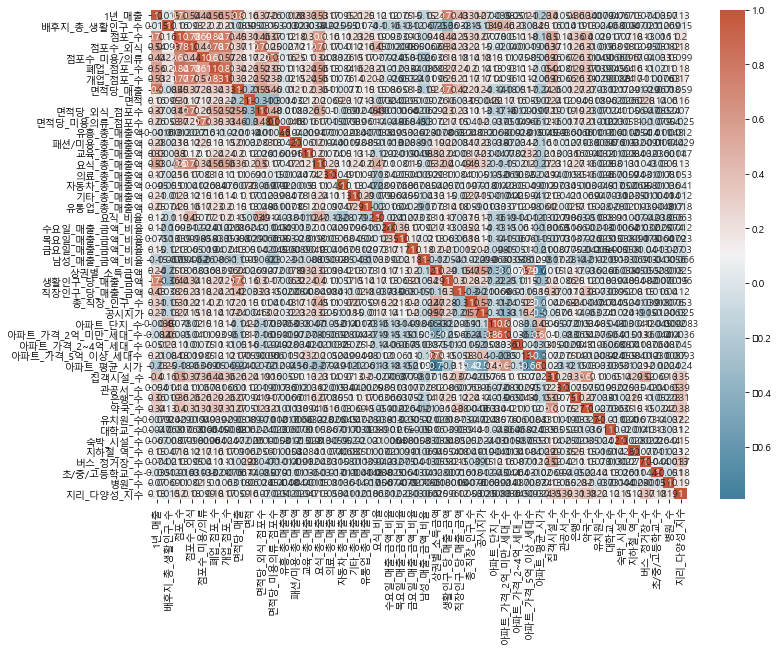

In [60]:
get_corr(df_all.drop(drop_features_by_vif,axis=1).iloc[:,1:])

##  영향력 평가

### 자료 설정

In [61]:
df_ready = df_all.drop(drop_features_by_vif, axis=1)

In [62]:
df_ready

,상권_코드,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,71.8997,59.2115,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.75

In [63]:
df_ready.columns

Index(['상권_코드', '1년_매출', '배후지_총_생활인구_수', '점포_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적당_매출', '면적', '면적당_외식_점포수', '면적당_미용의류_점포수', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '요식_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', '남성_매출_금액_비율', '상권별_소득금액', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [64]:
df_t_total = pd.read_csv('data/j_result/매출_회귀계수.csv')
df_t_total = get_object_type(df_t_total)
df_t_total

,상권_코드,coef
0,1000001,-97082931.6084
1,1000002,-323758770.8287
2,1000003,-278522715.1818
3,1000004,-148508140.6049
4,1000005,-162706767.6678
...,...,...
1485,1001486,220772059.9126
1486,1001487,-363803970.5490
1487,1001488,-1461056.8147
1488,1001489,-316501219.6399


In [65]:
df_ready = pd.merge(df_ready, df_t_total, how='left', on='상권_코드')
df_ready

,상권_코드,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수,coef
0,1000001,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775,-97082931.6084
1,1000002,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963,-323758770.8287
2,1000003,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824,-278522715.1818
3,1000004,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701,-148508140.6049
4,1000005,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931,-162706767.6678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,1001006,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365,-166135427.6434
985,1001007,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609,6801529.2622
986,1001008,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,71.8997,59.2115,

In [66]:
df_y = get_Standard(df_ready.iloc[:,-1])

In [67]:
df_X = df_ready.iloc[:,1:-1]

### 정규화 및 스케일링

In [68]:
df_X

,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,15126572384.0000,1081142.0000,204.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,40.8638,25.6132,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.5751,0.0783,0.0697,0.0813,0.3869,56459184,3497.8228,276032.3428,54800,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,15994662318.0000,3643150.7500,113.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,42.5330,75.0128,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.1175,0.0641,0.0638,0.0795,0.4013,52528944,1097.5844,339647.1230,47092,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,28743293882.0000,1732769.0000,284.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,57.9355,16.3684,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.2218,0.0752,0.0648,0.0755,0.5792,46548880,4147.0176,181891.9524,158024,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,10722057960.0000,3164952.7500,74.2500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,111.8913,6.6801,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.4183,0.0859,0.0715,0.0808,0.5498,47223072,846.9367,1580492.0342,6784,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,10434746482.0000,460215.0000,75.5000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,8.2778,1.0681,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.6290,0.0742,0.0600,0.0750,0.4819,63642816,5668.4085,613519.9013,17008,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,12500919837.0000,5769453.2500,129.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,16.6276,29.8151,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.2988,0.0777,0.0824,0.0675,0.5191,48022416,541.6856,1472775.6641,8488,4224172.7597,853.0000,6621.0000,15482.0000,3488.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
985,17237273313.0000,1411216.7500,165.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,84.3594,15.4205,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.1020,0.1039,0.0833,0.0878,0.6678,40991088,3053.6190,4460992.0582,3864,2451149.1166,377.0000,2274.0000,1092.0000,0.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
986,22670426878.0000,7262764.2500,155.0000,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,71.8997,59.2115,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.7594,0.0679,0.0674,0.0844,0.6205,44387424,780.3650,2264325.4972,10012,4373616.1

In [69]:
df_X.columns

Index(['1년_매출', '배후지_총_생활인구_수', '점포_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적당_매출', '면적', '면적당_외식_점포수', '면적당_미용의류_점포수', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '요식_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', '남성_매출_금액_비율', '상권별_소득금액', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수', '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [70]:
standard_list = ['1년_매출','배후지_총_생활인구_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', 
                 '개업_점포_수', '면적당_매출', '면적', '면적당_외식_점포수', '면적당_미용의류_점포수',
                 '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액',
                 '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액','총_직장_인구_수', 
                 '공시지가', '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수',
                 '아파트_가격_5억_이상_세대수', '아파트_평균_시가', '집객시설_수', '관공서_수', '은행_수', 
                 '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', 
                 '초/중/고등학교_수', '병원_수', 
                 '상권별_소득금액' ]

minmax_list = [ '고객_다양성_지수','생활인구_당_매출_금액', '직장인구_당_매출_금액','지리_다양성_지수']

itself_list = ['요식_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', 
              '남성_매출_금액_비율']

In [71]:
# for i in df_X.columns:
#     print(i)
#     if i in standard_list:
#         print('s')
#     if i in minmax_list:
#         print('m')
#     if i in itself_list:
#         print('it')
#     print('###')
#     print()

In [72]:
for col in df_X.columns:
    if col in standard_list:
        df_X[col] = get_Standard(df_X[col])
    if col in minmax_list:
        df_X[col] = get_MinMaxScaler(df_X[col])

In [73]:
df_X = sm.add_constant(df_X ,has_constant = "add")
df_X

,const,1년_매출,배후지_총_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_외식_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,요식_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,남성_매출_금액_비율,상권별_소득금액,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1.0000,-0.3029,-1.8035,204.0000,0.5759,0.4539,0.4355,0.7624,-0.5960,1.6726,-0.3265,-0.3888,-0.0574,-0.0383,-0.2158,0.5923,-0.2633,-0.4413,0.1454,-0.3407,0.5751,0.0783,0.0697,0.0813,0.3869,0.6122,0.1283,0.0164,0.8136,0.2515,-0.5504,-0.7154,-1.2470,-0.5786,-0.6629,0.1986,0.7449,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,0.7900,-0.2236,-0.2275,0.5720
1,1.0000,-0.2589,-0.4735,113.7500,-0.9016,-0.0531,-0.7026,-1.1195,0.6127,-1.4187,-0.2851,1.3920,-0.0475,0.6808,-0.3755,-0.7037,-0.2943,-0.4446,-0.2752,-0.4422,0.1175,0.0641,0.0638,0.0795,0.4013,0.2711,0.0402,0.0202,0.5972,-0.1738,-1.0852,-0.4511,-0.0019,0.1779,-0.4423,-0.7405,-0.6347,1.2858,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.5524,-0.2236,-0.2275,0.5859
2,1.0000,0.3875,-1.4652,284.0000,1.1515,-0.3662,1.9876,0.2247,-0.1808,1.2912,0.0970,-0.7220,0.1999,0.1978,4.0765,0.0471,-0.2934,-0.3946,-0.1978,-0.3312,0.2218,0.0752,0.0648,0.0755,0.5792,-0.2480,0.1522,0.0108,3.7128,3.5899,-1.3005,-1.0210,-1.0543,-0.6463,0.2125,3.0160,0.7449,-0.4610,-0.9272,2.4460,2.0145,5.9009,-0.1771,0.7900,7.0276,-0.2275,0.7963
3,1.0000,-0.5262,-0.7217,74.2500,0.4991,-1.3205,-0.3922,-0.7610,-0.2093,-1.0116,1.4353,-1.0712,-0.0794,-0.2643,-0.3239,-0.3853,-0.2485,-0.4426,-0.2988,-0.2317,0.4183,0.0859,0.0715,0.0808,0.5498,-0.1895,0.0310,0.0945,-0.5349,0.1142,-0.0040,-0.3871,-0.9020,-0.6120,0.7801,-0.2709,-0.6347,-0.4610,0.5898,-0.3506,-0.1347,-0.2165,-0.1771,1.2374,-0.2236,-0.2275,0.7137
4,1.0000,-0.5408,-2.1259,75.5000,-0.2396,-1.2609,-1.1165,-0.6714,-0.8864,9.6531,-1.1348,-1.2735,-0.0824,-0.1819,-0.3046,1.1135,-0.2943,0.5263,-0.1359,-0.4987,0.6290,0.0742,0.0600,0.0750,0.4819,1.2357,0.2080,0.0366,-0.2478,-1.0702,-0.7306,-0.9826,-0.8543,-0.3684,-1.1527,-1.0535,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,0.3425,-0.2236,-0.2275,0.5100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,1.0000,-0.4360,0.6304,129.2500,-0.8728,0.0513,-0.0818,-0.6714,-0.5156,0.3570,-0.9277,-0.2373,-0.0560,-0.1707,-0.1329,-0.3301,-0.2873,-0.3224,0.0763,-0.1452,0.2988,0.0777,0.0824,0.0675,0.5191,-0.1201,0.0197,0.0880,-0.4871,0.0568,-0.0977,-0.0731,2.3257,0.3170,-0.3556,-0.8970,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,-0.2236,-0.2275,0.4683
985,1.0000,-0.1959,-1.6322,165.7500,1.2474,-0.7390,0.4355,0.4936,-0.3065,0.2106,0.7524,-0.7562,-0.0789,-0.1514,-0.3118,-0.1917,-0.2382,2.7963,0.2206,2.7440,0.1020,0.1039,0.0833,0.0878,0.6678,-0.7304,0.1120,0.2669,-0.6170,-0.7083,-0.7951,-0.8038,-1.1248,-0.6463,0.6441,0.5117,0.7449,-0.4610,-0.1687,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,3.4020,-0.2275,0.7069
986,1.0000,0.0796,1.4056,155.0000,0.5279,1.0056,0.2286,-0.2234,0.0503,-0.1696,0.4433,0.8224,-0.0440,0.0110,-0.3579,0.5166,-0.2943,-0.4330,-0.2991,-0.5694,0.7594,0.0679,0.0674,0.0844,0.6205,-0.4356,0.0285,0.1354,-0.4443,0.1213,-0.4830,-0.5321,-0.3311,-0.6341,0.0924,-1.2101,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.5524,-0.2236,-0.2275,0.4683
987,1.0000,-0.6284,2.1597,183.0000,-0.0094,-0.0084,0.2286,-0.2234,-0.6975,0.7854,-0.4264,-0.4148,-0.0753,-0.2523,-0.1047,-0.5713,0.0491,0.6172,0.4041,-0.3218,0.0962,0.0812,0.0697,0.0870,0.5664,0.0820,0.0090,0.0214,-0.0442,0.1213,-0.2266,-0.4405,0.7522,0.1060,-0.1439,-0.5840,0.7449,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,-0.2236,-0.2275,0.6244


### AIC 모델

In [74]:
s_AIC_model = Stepwise_model(df_X, df_y)

Processed 46 models on 1 predictors in 0.13712215423583984 seconds.
['생활인구_당_매출_금액']
step: 1
Processed  45 models on 2 predictors in 0.12311172485351562
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B0270D0>
Processed  1 models on 0 predictors in 0.004003763198852539
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B0B4E20>
##forward##
step: 2
Processed  44 models on 3 predictors in 0.1211097240447998
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', '1년_매출', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1AFE3C40>
Processed  2 models on 1 predictors in 0.006005764007568359
Selected predictors: ['생활인구_당_매출_금액', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B27ABE0>
##forward##
step: 3
Processed  43 models on 4 predictor

Processed  15 models on 14 predictors in 0.0470433235168457
Selected predictors: ['생활인구_당_매출_금액', '1년_매출', '점포_수', '집객시설_수', '상권별_소득금액', '요식_총_매출액', '배후지_총_생활인구_수', '목요일_매출_금액_비율', '점포수_미용/의류', '면적당_미용의류_점포수', '금요일_매출_금액_비율', '개업_점포_수', '폐업_점포_수', '숙박_시설_수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B0485E0>
##forward##
step: 16
Processed  30 models on 17 predictors in 0.10109114646911621
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', '1년_매출', '점포_수', '집객시설_수', '상권별_소득금액', '요식_총_매출액', '배후지_총_생활인구_수', '목요일_매출_금액_비율', '점포수_미용/의류', '면적당_미용의류_점포수', '금요일_매출_금액_비율', '개업_점포_수', '폐업_점포_수', '숙박_시설_수', '총_직장_인구_수', '의료_총_매출액', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B41F190>
Processed  16 models on 15 predictors in 0.05404949188232422
Selected predictors: ['생활인구_당_매출_금액', '1년_매출', '점포_수', '집객시설_수', '상권별_소득금액', '요식_총_매출액', '배후지_총_생활인구_수', '목요일_매출_금액_비율', '점포수_미용/의류', '면적당_미용의류_점포수', 

Processed  23 models on 22 predictors in 0.07225227355957031
Selected predictors: ['생활인구_당_매출_금액', '1년_매출', '점포_수', '집객시설_수', '상권별_소득금액', '요식_총_매출액', '배후지_총_생활인구_수', '목요일_매출_금액_비율', '점포수_미용/의류', '면적당_미용의류_점포수', '금요일_매출_금액_비율', '개업_점포_수', '폐업_점포_수', '숙박_시설_수', '총_직장_인구_수', '의료_총_매출액', '관공서_수', '남성_매출_금액_비율', '교육_총_매출액', '초/중/고등학교_수', '면적', '면적당_외식_점포수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B0089D0>
##forward##
step: 26
Processed  22 models on 25 predictors in 0.07306599617004395
Selected predictors: ['생활인구_당_매출_금액', '1년_매출', '점포_수', '집객시설_수', '상권별_소득금액', '요식_총_매출액', '배후지_총_생활인구_수', '목요일_매출_금액_비율', '점포수_미용/의류', '면적당_미용의류_점포수', '금요일_매출_금액_비율', '개업_점포_수', '폐업_점포_수', '숙박_시설_수', '총_직장_인구_수', '의료_총_매출액', '관공서_수', '남성_매출_금액_비율', '아파트_가격_5억_이상_세대수', '교육_총_매출액', '초/중/고등학교_수', '면적', '면적당_외식_점포수', '버스_정거장_수', '유치원_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1AB2F130>
Processed  24 

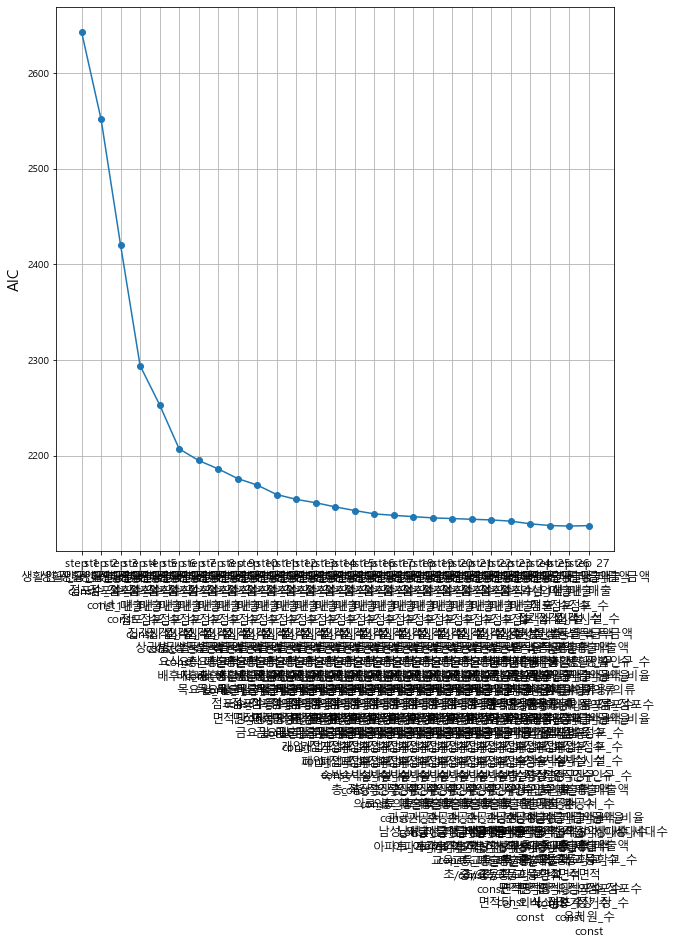

In [75]:
vis_AIC_step(s_AIC_model)

In [76]:
b_AIC_model = backward_model(df_X, df_y)

Processed  46 models on 45 predictors in 0.27919936180114746
Selected predictors: ['1년_매출', '개업_점포_수', '공시지가', '관공서_수', '교육_총_매출액', '금요일_매출_금액_비율', '기타_총_매출액', '남성_매출_금액_비율', '면적', '면적당_매출', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '배후지_총_생활인구_수', '버스_정거장_수', '병원_수', '상권별_소득금액', '생활인구_당_매출_금액', '수요일_매출_금액_비율', '숙박_시설_수', '아파트_가격_2~4억_세대_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_5억_이상_세대수', '아파트_단지_수', '아파트_평균_시가', '약국_수', '요식_비율', '요식_총_매출액', '유치원_수', '유통업_총_매출액', '유흥_총_매출액', '은행_수', '의료_총_매출액', '자동차_총_매출액', '점포_수', '점포수_미용/의류', '점포수_외식', '지리_다양성_지수', '지하철_역_수', '직장인구_당_매출_금액', '집객시설_수', '초/중/고등학교_수', '총_직장_인구_수', '패션/미용_총_매출액', '폐업_점포_수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B19CD8DF0>
Processed  45 models on 44 predictors in 0.2642402648925781
Selected predictors: ['1년_매출', '개업_점포_수', '공시지가', '관공서_수', '교육_총_매출액', '금요일_매출_금액_비율', '기타_총_매출액', '남성_매출_금액_비율', '면적', '면적당_매출', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '배후지_총_생활인구_수

Processed  33 models on 32 predictors in 0.1961808204650879
Selected predictors: ['1년_매출', '개업_점포_수', '관공서_수', '교육_총_매출액', '금요일_매출_금액_비율', '남성_매출_금액_비율', '면적', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '배후지_총_생활인구_수', '버스_정거장_수', '상권별_소득금액', '생활인구_당_매출_금액', '수요일_매출_금액_비율', '숙박_시설_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '요식_비율', '요식_총_매출액', '유치원_수', '유통업_총_매출액', '은행_수', '의료_총_매출액', '자동차_총_매출액', '점포_수', '점포수_미용/의류', '지리_다양성_지수', '집객시설_수', '초/중/고등학교_수', '총_직장_인구_수', '폐업_점포_수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1AB3C370>
Processed  32 models on 31 predictors in 0.12811708450317383
Selected predictors: ['1년_매출', '개업_점포_수', '관공서_수', '교육_총_매출액', '금요일_매출_금액_비율', '남성_매출_금액_비율', '면적', '면적당_미용의류_점포수', '면적당_외식_점포수', '목요일_매출_금액_비율', '배후지_총_생활인구_수', '버스_정거장_수', '상권별_소득금액', '생활인구_당_매출_금액', '수요일_매출_금액_비율', '숙박_시설_수', '아파트_가격_2~4억_세대_수', '아파트_가격_5억_이상_세대수', '요식_총_매출액', '유치원_수', '유통업_총_매출액', '은행_수', '의료_총_매출액', '자동차_총_매출액', '점포_수', '

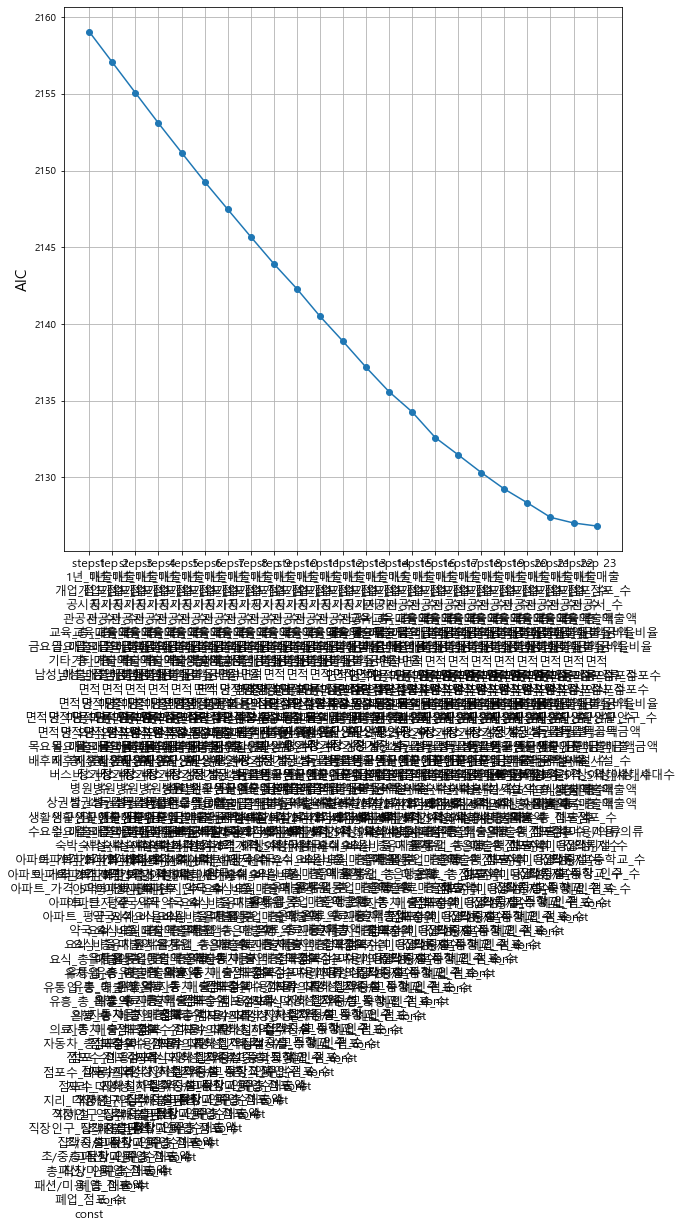

In [77]:
vis_AIC_step(b_AIC_model)

Processed  46 models on 1 predictors in 0.19518399238586426
Selected predictors: ['생활인구_당_매출_금액', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1A14FC40>
Processed  45 models on 2 predictors in 0.1191091537475586
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B19994400>
Processed  44 models on 3 predictors in 0.11910700798034668
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', '1년_매출', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B19A9BBE0>
Processed  43 models on 4 predictors in 0.1040945053100586
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', '1년_매출', '점포_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1A193CA0>
Processed  42 models on 5 predictors in 0.10609626770019531
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', '1년_매출', '점포_수', '

Processed  21 models on 26 predictors in 0.17215633392333984
Selected predictors: ['생활인구_당_매출_금액', '점포수_외식', '1년_매출', '점포_수', '집객시설_수', '상권별_소득금액', '요식_총_매출액', '배후지_총_생활인구_수', '목요일_매출_금액_비율', '점포수_미용/의류', '면적당_미용의류_점포수', '금요일_매출_금액_비율', '개업_점포_수', '폐업_점포_수', '숙박_시설_수', '총_직장_인구_수', '의료_총_매출액', '관공서_수', '남성_매출_금액_비율', '아파트_가격_5억_이상_세대수', '교육_총_매출액', '초/중/고등학교_수', '면적', '면적당_외식_점포수', '버스_정거장_수', '유치원_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026B1B188F10>
Total elapsed time: 3.1558544635772705 seconds.


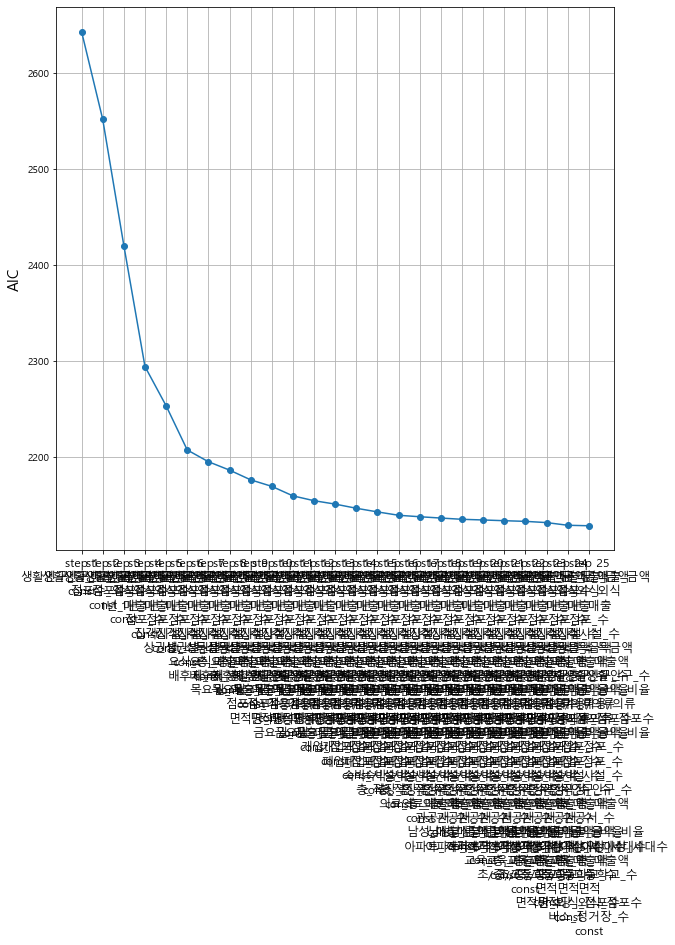

In [78]:
f_AIC_model = forward_model(df_X, df_y)
vis_AIC_step(f_AIC_model)

### R_square 모델

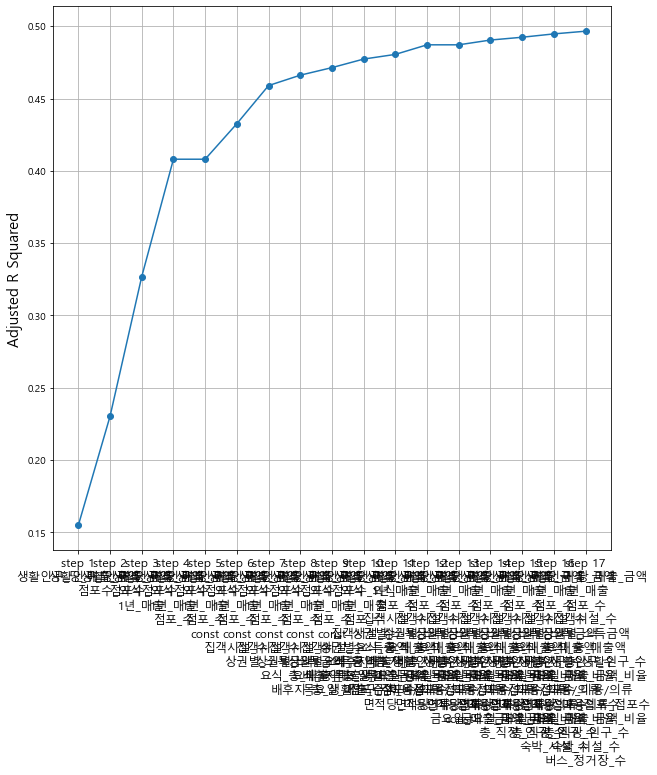

In [79]:
s_R_model = stepwise_R_sq(df_X, df_y)

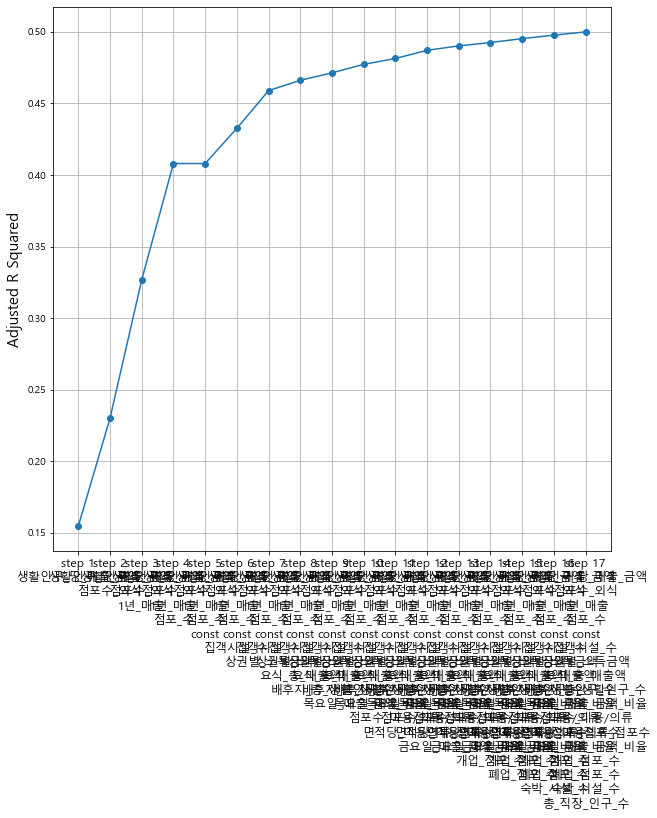

In [80]:
f_R_model = forward_R_sq(df_X, df_y)

In [81]:
f_R_model.sort_values('R_square', ascending=False).head().Features.to_frame()

,Features
17,"[생활인구_당_매출_금액, 점포수_외식, 1년_매출, 점포_수, const, 집객시..."
16,"[생활인구_당_매출_금액, 점포수_외식, 1년_매출, 점포_수, const, 집객시..."
15,"[생활인구_당_매출_금액, 점포수_외식, 1년_매출, 점포_수, const, 집객시..."
14,"[생활인구_당_매출_금액, 점포수_외식, 1년_매출, 점포_수, const, 집객시..."
13,"[생활인구_당_매출_금액, 점포수_외식, 1년_매출, 점포_수, const, 집객시..."


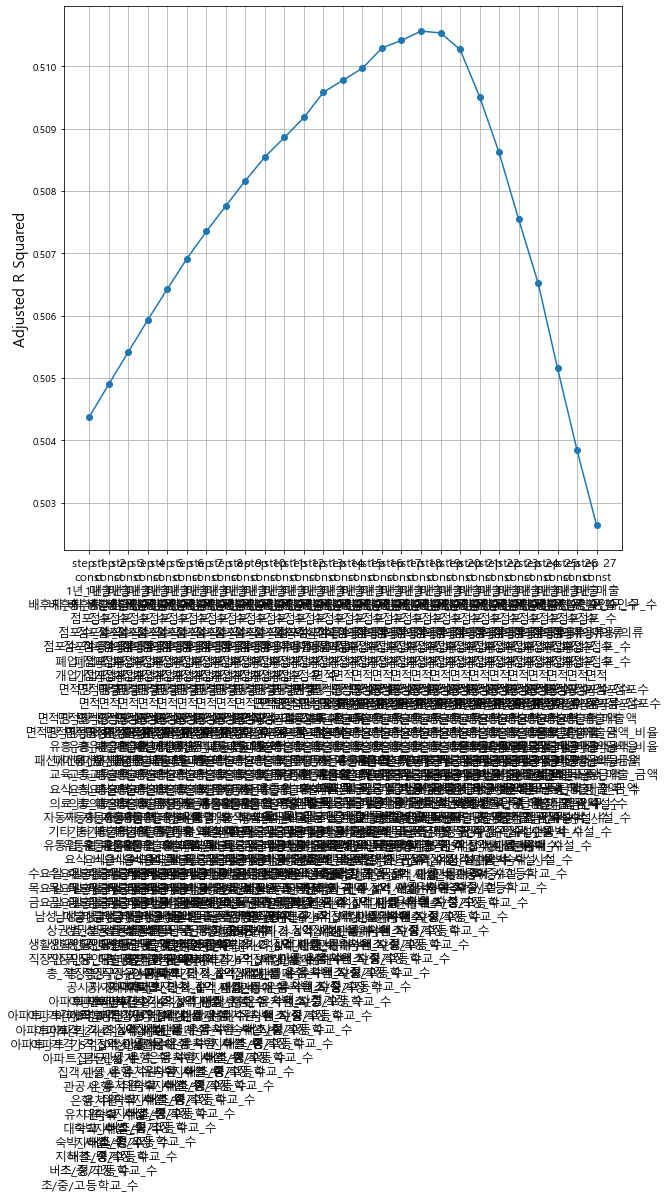

In [82]:
b_R_mdoel = backward_R_sq(df_X, df_y)

## 유효한 피쳐 선택

s_AIC_model
b_AIC_model
f_AIC_model

s_R_model
b_R_mdoel
f_R_model

In [83]:
s_AIC_model.sort_values('AIC').head(1)['SUMMARY'][26]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     43.89
Date:                Sun, 17 Oct 2021   Prob (F-statistic):          1.93e-136
Time:                        18:59:11   Log-Likelihood:                -1038.1
No. Observations:                 989   AIC:                             2126.
Df Residuals:                     964   BIC:                             2249.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
생활인구_당_매출_금액         4.1949      0.629      6.672      0.000       2.961       5.429
1년_매출                0.7467      0.048     15.413      0.000       0.652       0.842
점포_수                -0.0082      0.001     -9.376      0.000      -0.010      -0.006
집객시설_수              -0.2136      0.034     -6.228      0.000      -0.281      -0.146
상권별_소득금액            -0.1242      0.044     -2.835      0.005      -0.210      -0.038
요식_총_매출액            -0.1104      0.035     -3.148      0.002      -0.179      -0.042
배후지_총_생활인구_수         0.1070      0.028      3.761      0.000       0.051       0.163
목요일_매출_금액_비율         6.2518      1.686      3.709      0.000       2.944       9.560
점포수_미용/의류            0.2296      0.060      3.827      0.000       0.112       0.347
면적당_미용의류_점포수        -0.1119      0.052     -2.162      0.031      -0.213      -0.010
금요일_매출_금액_비율         4.6724      1.910      2.446      0.015       0.924       8.421
개업_점포_수              0.1440      0.044      3.236      0.001       0.057       0.231
폐업_점포_수             -0.1271      0.050     -2.562      0.011      -0.224      -0.030
숙박_시설_수              0.0598      0.023      2.598      0.010       0.015       0.105
총_직장_인구_수           -0.0650      0.028     -2.284      0.023      -0.121      -0.009
의료_총_매출액            -0.0432      0.023     -1.861      0.063      -0.089       0.002
관공서_수               -0.0436      0.024     -1.829      0.068      -0.090       0.003
남성_매출_금액_비율          0.5416      0.297      1.825      0.068      -0.041       1.124
아파트_가격_5억_이상_세대수     0.0635      0.039      1.637      0.102      -0.013       0.139
교육_총_매출액            -0.0471      0.026     -1.824      0.068      -0.098       0.004
초/중/고등학교_수           0.0420      0.023      1.844      0.065      -0.003       0.087
면적                  -0.0903      0.034     -2.670      0.008      -0.157      -0.024
면적당_외식_점포수          -0.1118      0.042     -2.672      0.008      -0.194      -0.030
버스_정거장_수             0.0449      0.028      1.578      0.115      -0.011       0.101
const               -0.2209      0.247     -0.895      0.371      -0.706       0.264
==============================================================================
Omnibus:                     1248.120   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           444836.725
Skew:                          -6.104   Prob(JB):                         0.00
Kurtosis:                     106.178   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical probl

In [84]:
b_R_mdoel.sort_values('R_square', ascending=False).head(1)['SUMMARY'][18]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     40.64
Date:                Sun, 17 Oct 2021   Prob (F-statistic):          2.42e-135
Time:                        18:59:27   Log-Likelihood:                -1036.8
No. Observations:                 989   AIC:                             2128.
Df Residuals:                     962   BIC:                             2260.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2969      0.258     -1.152      0.250      -0.803       0.209
1년_매출                0.7475      0.048     15.413      0.000       0.652       0.843
배후지_총_생활인구_수         0.1092      0.029      3.825      0.000       0.053       0.165
점포_수                -0.0083      0.001     -9.398      0.000      -0.010      -0.007
점포수_미용/의류            0.2302      0.060      3.834      0.000       0.112       0.348
폐업_점포_수             -0.1262      0.050     -2.539      0.011      -0.224      -0.029
개업_점포_수              0.1438      0.044      3.232      0.001       0.057       0.231
면적                  -0.0894      0.034     -2.643      0.008      -0.156      -0.023
면적당_외식_점포수          -0.1067      0.042     -2.543      0.011      -0.189      -0.024
면적당_미용의류_점포수        -0.1120      0.052     -2.165      0.031      -0.214      -0.011
교육_총_매출액            -0.0457      0.026     -1.770      0.077      -0.096       0.005
요식_총_매출액            -0.1102      0.035     -3.144      0.002      -0.179      -0.041
의료_총_매출액            -0.0423      0.023     -1.821      0.069      -0.088       0.003
수요일_매출_금액_비율         1.8861      1.833      1.029      0.304      -1.711       5.483
목요일_매출_금액_비율         5.7258      1.758      3.257      0.001       2.276       9.176
금요일_매출_금액_비율         4.5814      1.911      2.397      0.017       0.830       8.332
남성_매출_금액_비율          0.5140      0.298      1.727      0.085      -0.070       1.098
상권별_소득금액            -0.1257      0.044     -2.870      0.004      -0.212      -0.040
생활인구_당_매출_금액         4.1677      0.630      6.618      0.000       2.932       5.404
총_직장_인구_수           -0.0664      0.029     -2.323      0.020      -0.122      -0.010
아파트_가격_5억_이상_세대수     0.0640      0.039      1.653      0.099      -0.012       0.140
집객시설_수              -0.2182      0.034     -6.337      0.000      -0.286      -0.151
관공서_수               -0.0433      0.024     -1.815      0.070      -0.090       0.004
유치원_수                0.0281      0.023      1.232      0.218      -0.017       0.073
숙박_시설_수              0.0616      0.023      2.675      0.008       0.016       0.107
버스_정거장_수             0.0461      0.028      1.619      0.106      -0.010       0.102
초/중/고등학교_수           0.0384      0.023      1.675      0.094      -0.007       0.083
==============================================================================
Omnibus:                     1250.553   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           448130.507
Skew:                          -6.126   Prob(JB):                         0.00
Kurtosis:                     106.560   Cond. No.                     1.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matr

# 최종 feature 선택

In [89]:
AIC_feature_list = s_AIC_model.sort_values('AIC').head(1)['Features'][26]

In [90]:
R_feature_list = b_R_mdoel.sort_values('R_square', ascending=False).head(1)['Features'][18]

In [91]:
최종_feature = list(set(AIC_feature_list + R_feature_list))

In [92]:
최종_feature

['버스_정거장_수',
 '초/중/고등학교_수',
 '숙박_시설_수',
 '1년_매출',
 '면적당_외식_점포수',
 '의료_총_매출액',
 'const',
 '점포수_미용/의류',
 '유치원_수',
 '관공서_수',
 '면적',
 '금요일_매출_금액_비율',
 '배후지_총_생활인구_수',
 '생활인구_당_매출_금액',
 '목요일_매출_금액_비율',
 '폐업_점포_수',
 '남성_매출_금액_비율',
 '상권별_소득금액',
 '개업_점포_수',
 '총_직장_인구_수',
 '점포_수',
 '교육_총_매출액',
 '집객시설_수',
 '요식_총_매출액',
 '아파트_가격_5억_이상_세대수',
 '면적당_미용의류_점포수',
 '수요일_매출_금액_비율']

In [93]:
import pickle
 
## Save pickle
with open("data/indicator/회귀기반_정규화_feature.pickle","wb") as fw:
    pickle.dump(최종_feature, fw)
 